In [11]:
# Mean Reversion — 01_download_yf
# Downloads daily adjusted close prices via yfinance, cleans, saves Parquet,
# and does quick EDA + plots for sanity checks.

# 0) Setup
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# ICBC, CCB, BOC, ABC
banks = ['1398.HK', '0939.HK', '3988.HK', '1288.HK']

In [22]:
# 1) Configuration
TICKERS = banks
START = "2010-01-01"


print(f"Universe size: {len(TICKERS)} | Start: {START}")

# 2) Download Adjusted Close Prices
# We prefer 'Adj Close' to reflect total-return adjustments
raw = yf.download(TICKERS, start=START, auto_adjust=False, progress=True).dropna()
prices = raw["Adj Close"].sort_index()
print("Raw prices shape:", prices.shape)
prices.head()

Universe size: 4 | Start: 2010-01-01


[*********************100%***********************]  4 of 4 completed

Raw prices shape: (3770, 4)


Ticker,0939.HK,1288.HK,1398.HK,3988.HK
Date,,,,
2010-07-16,2.512943,1.304351,2.337332,1.492374
2010-07-19,2.497039,1.280418,2.329117,1.463326
2010-07-20,2.540776,1.276429,2.357871,1.470588
2010-07-21,2.572586,1.280418,2.378410,1.488743
2010-07-22,2.584514,1.300362,2.390733,1.496005


In [23]:
# 3) Compute Returns (Log)
returns = np.log(prices / prices.shift(1))
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna(how="all")
returns.head()

Ticker,0939.HK,1288.HK,1398.HK,3988.HK
Date,,,,
2010-07-19,-0.006349,-0.018519,-0.003521,-0.019656
2010-07-20,0.017364,-0.003120,0.012270,0.004950
2010-07-21,0.012442,0.003120,0.008673,0.012270
2010-07-22,0.004626,0.015456,0.005168,0.004866
2010-07-23,0.012233,0.047913,0.010257,0.007255


In [24]:
# 4) Quick EDA
# Missingness by ticker
na_frac = prices.isna().mean().sort_values(ascending=False)
na_frac.to_frame("na_fraction")

,na_fraction
Ticker,
0939.HK,0.0
1288.HK,0.0
1398.HK,0.0
3988.HK,0.0


In [25]:
# Summary stats of returns (wide)
display(returns.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T)

# Rolling correlation snapshot (252d)
window = 252
if returns.shape[0] > window:
    corr_rolling = returns.rolling(window).corr().dropna()
    last_date = corr_rolling.index.get_level_values(0).max()
    corr_last = corr_rolling.xs(last_date)
    print("Rolling correlation snapshot (last date):", last_date)
    display(corr_last)
else:
    print("Not enough data for rolling correlations.")

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Ticker,,,,,,,,,,,,
0939.HK,3769.0,0.000297,0.014528,-0.095600,-0.035243,-0.022167,-0.008190,0.0,0.008397,0.023516,0.040380,0.070682
1288.HK,3769.0,0.000401,0.015409,-0.095527,-0.037740,-0.023134,-0.008011,0.0,0.008559,0.024558,0.041653,0.120714
1398.HK,3769.0,0.000251,0.014945,-0.090696,-0.037495,-0.022625,-0.008368,0.0,0.008475,0.024726,0.040275,0.101409
3988.HK,3769.0,0.000287,0.013663,-0.112117,-0.034042,-0.021098,-0.007220,0.0,0.007435,0.022260,0.036685,0.098699


Rolling correlation snapshot (last date): 2025-10-31 00:00:00


Ticker,0939.HK,1288.HK,1398.HK,3988.HK
Ticker,,,,
0939.HK,1.000000,0.761541,0.894463,0.859830
1288.HK,0.761541,1.000000,0.782625,0.758114
1398.HK,0.894463,0.782625,1.000000,0.843050
3988.HK,0.859830,0.758114,0.843050,1.000000


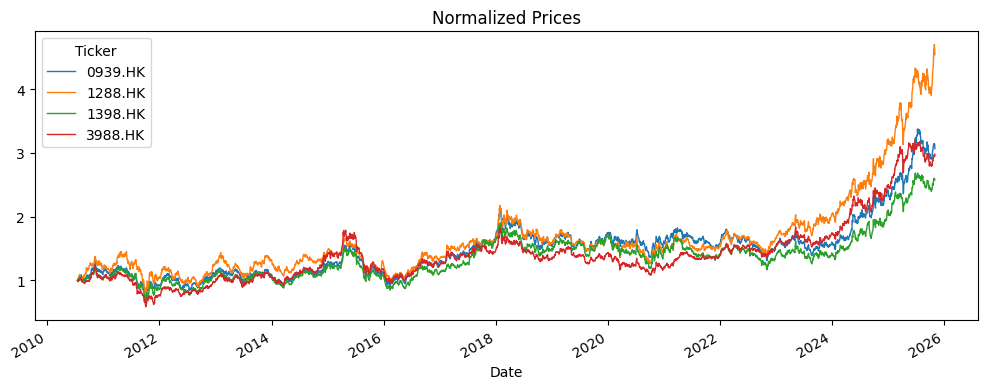

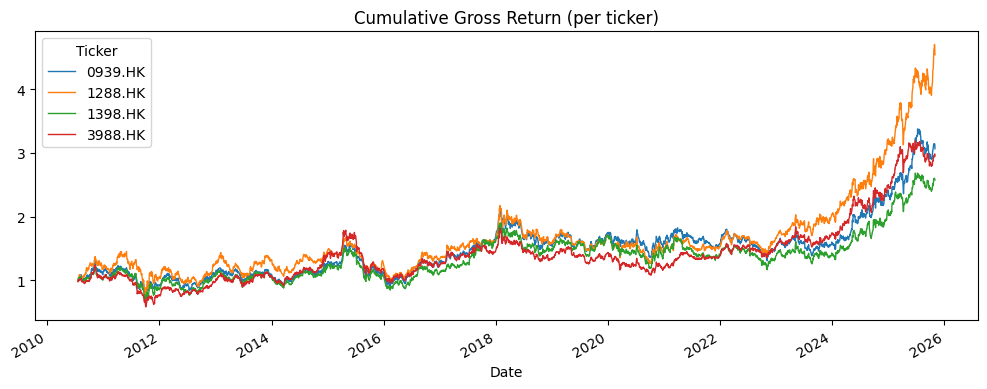

Next: open 02_single_stock_zscore.ipynb to build rolling z-score signals, entry/exit rules, vol scaling, and a basic backtest with transaction costs.


In [26]:
# 7) Sanity Plots
# (A) Normalized price levels
plt.figure(figsize=(10,4))
norm = prices / prices.iloc[0]
norm.plot(ax=plt.gca(), lw=1)
plt.title("Normalized Prices")
plt.tight_layout()
plt.show()

# (B) Cumulative gross returns (per ticker)
plt.figure(figsize=(10,4))
cumret = returns.fillna(0).cumsum().apply(np.exp)
cumret.plot(ax=plt.gca(), lw=1)
plt.title("Cumulative Gross Return (per ticker)")
plt.tight_layout()
plt.show()

# 8) Next Steps (for your reference)
print(
    "Next: open 02_single_stock_zscore.ipynb to build rolling z-score signals, "
    "entry/exit rules, vol scaling, and a basic backtest with transaction costs."
)

Price          Close                                    High            \
Ticker       0939.HK   1288.HK   1398.HK   3988.HK   0939.HK   1288.HK   
Date                                                                     
2010-07-16  2.512944  1.304351  2.337332  1.492374  2.560658  1.320306   
2010-07-19  2.497039  1.280418  2.329117  1.463326  2.512943  1.280418   
2010-07-20  2.540776  1.276429  2.357871  1.470588  2.556680  1.288395   
2010-07-21  2.572586  1.280418  2.378410  1.488743  2.576562  1.288396   
2010-07-22  2.584515  1.300362  2.390733  1.496006  2.584515  1.300362   
...              ...       ...       ...       ...       ...       ...   
2025-10-24  7.890000  6.030000  6.070000  4.390000  7.930000  6.050000   
2025-10-27  7.880000  6.060000  6.080000  4.420000  7.950000  6.170000   
2025-10-28  7.900000  6.130000  6.060000  4.440000  7.940000  6.140000   
2025-10-30  7.860000  6.020000  6.050000  4.450000  7.970000  6.180000   
2025-10-31  7.700000  5.920000  6.020000  4.400000  7.880000  6.050000   

Price                                Low                                \
Ticker       1398.HK   3988.HK   0939.HK   1288.HK   1398.HK   3988.HK   
Date                                                                     
2010-07-16  2.374302  1.506899  2.504991  1.296373  2.337332  1.459695   
2010-07-19  2.341440  1.477850  2.485110  1.280418  2.316793  1.459695   
2010-07-20  2.382518  1.481481  2.497038  1.276429  2.329117  1.463326   
2010-07-21  2.382518  1.488743  2.564633  1.280418  2.361979  1.474219   
2010-07-22  2.390733  1.496006  2.552705  1.300362  2.370194  1.481481   
...              ...       ...       ...       ...       ...       ...   
2025-10-24  6.080000  4.410000  7.830000  5.910000  6.020000  4.370000   
2025-10-27  6.110000  4.440000  7.800000  5.980000  5.980000  4.360000   
2025-10-28  6.100000  4.460000  7.820000  6.050000  6.030000  4.400000   
2025-10-30  6.110000  4.550000  7.820000  5.920000  6.030000  4.430000   
2025-10-31  6.100000  4.480000  7.680000  5.900000  6.000000  4.400000   

Price           Open                                   Volume                \
Ticker       0939.HK   1288.HK   1398.HK   3988.HK    0939.HK       1288.HK   
Date                                                                          
2010-07-16  2.528848  1.296373  2.370194  1.481481  205890723  3.191766e+09   
2010-07-19  2.489086  1.280418  2.320901  1.474219  160315283  0.000000e+00   
2010-07-20  2.497038  1.276429  2.329117  1.463326  191974890  2.993739e+08   
2010-07-21  2.576562  1.280418  2.370194  1.481481  196158832  2.069371e+08   
2010-07-22  2.568610  1.300362  2.378410  1.488743  175046986  0.000000e+00   
...              ...       ...       ...       ...        ...           ...   
2025-10-24  7.930000  5.950000  6.060000  4.410000  215698486  1.503765e+08   
2025-10-27  7.950000  6.070000  6.080000  4.430000  219898505  1.923681e+08   
2025-10-28  7.900000  6.100000  6.080000  4.440000  225912075  1.508827e+08   
2025-10-30  7.950000  6.140000  6.090000  4.470000  299849276  3.009898e+08   
2025-10-31  7.860000  6.020000  6.040000  4.460000  405939201  2.043162e+08   

Price                                 
Ticker          1398.HK      3988.HK  
Date                                  
2010-07-16  195043949.0  529884680.0  
2010-07-19  141214777.0  245282714.0  
2010-07-20  191225063.0  221292096.0  
2010-07-21  155587924.0  193094927.0  
2010-07-22  117100215.0  219326235.0  
...                 ...          ...  
2025-10-24  176096467.0  142454985.0  
2025-10-27  205602530.0  232974843.0  
2025-10-28  199529931.0  177711676.0  
2025-10-30  306345358.0  382631479.0  
2025-10-31  303567316.0  278191282.0  

[3770 rows x 20 columns]